In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from tensorflow.keras.preprocessing import image
#import sklearn
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
#from tensorflow import keras
#from keras.preprocessing.image import load_img

#from tensorflow.keras.layers import Activation
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import backend as K
#from sklearn.metrics import accuracy_score, classification_report
#from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

### Data Import

In [2]:
# Get the path to the normal and pneumonia sub-directories
normal_train = 'data/train/NORMAL'
pneumonia_train = 'data/train/PNEUMONIA'

In [3]:
# randomly choosing 3 normal samples
a = random.choice(os.listdir(normal_train))
b = random.choice(os.listdir(normal_train))
c = random.choice(os.listdir(normal_train))

# get full relative path
file_a = normal_train+'/'+a
file_b = normal_train+'/'+b
file_c = normal_train+'/'+c

# load images from relative paths
img_a = image.load_img(file_a)
img_b = image.load_img(file_b)
img_c = image.load_img(file_c)

Normal X-ray Sample 1: IM-0250-0001.jpeg


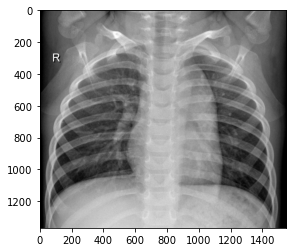

In [4]:
print('Normal X-ray Sample 1:', a)
plt.imshow(img_a)
plt.show()

Normal X-ray Sample 2: NORMAL2-IM-1256-0001.jpeg


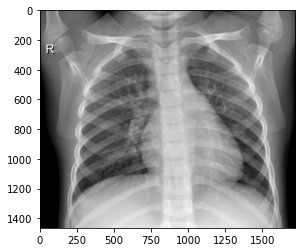

In [5]:
print('Normal X-ray Sample 2:', b)
plt.imshow(img_b)
plt.show()

Normal X-ray Sample 3: IM-0656-0001-0001.jpeg


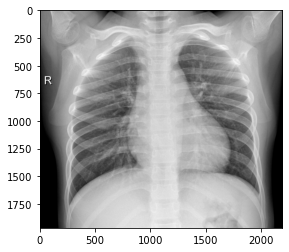

In [6]:
print('Normal X-ray Sample 3:', c)
plt.imshow(img_c)
plt.show()

In [7]:
# randomly choosing 3 pneumonia samples
x = random.choice(os.listdir(pneumonia_train))
y = random.choice(os.listdir(pneumonia_train))
z = random.choice(os.listdir(pneumonia_train))

# get full relative path
file_x = pneumonia_train+'/'+x
file_y = pneumonia_train+'/'+y
file_z = pneumonia_train+'/'+z

# load images from relative paths
img_x = image.load_img(file_x)
img_y = image.load_img(file_y)
img_z = image.load_img(file_z)

Pneumonia X-ray Sample 1: person1444_bacteria_3732.jpeg


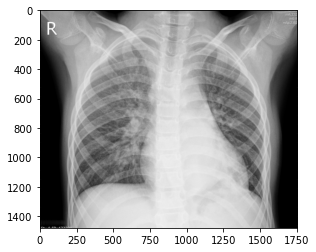

In [8]:
print('Pneumonia X-ray Sample 1:', x)
plt.imshow(img_x)
plt.show()

Pneumonia X-ray Sample 2: person651_bacteria_2543.jpeg


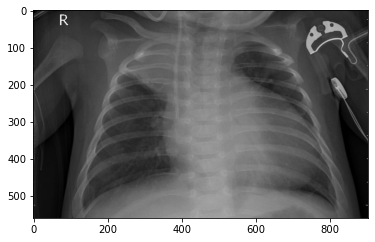

In [9]:
print('Pneumonia X-ray Sample 2:', y)
plt.imshow(img_y)
plt.show()

Pneumonia X-ray Sample 3: person487_bacteria_2059.jpeg


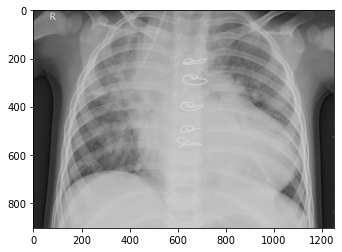

In [10]:
print('Pneumonia X-ray Sample 3:', z)
plt.imshow(img_z)
plt.show()

### Exploratory Analysis

In [11]:
# define target labels
target_labels = ['PNEUMONIA', 'NORMAL']

# define function to get data from the directories & store in array
def get_data(mydir):
    # initialize data array 
    xray_data = [] 
    for label in target_labels: 
        # define full path w/ subfolder
        full_path = os.path.join(mydir, label)
        
        # index on label
        num = target_labels.index(label)
        
        for img in os.listdir(full_path):
            try:
                # read the images
                img_arr = cv2.imread(os.path.join(full_path, img), cv2.IMREAD_GRAYSCALE)
                
                # resize the images
                resized = cv2.resize(img_arr, (150, 150))
                
                # append to xray_data
                xray_data.append([resized, num])
                
            except Exception as e:
                print(e)
                
    # return data array            
    return np.array(xray_data)

In [12]:
# apply function to test/train/validation data directories
train_data = get_data('data/train')
test_data = get_data('data/test')
val_data = get_data('data/val')

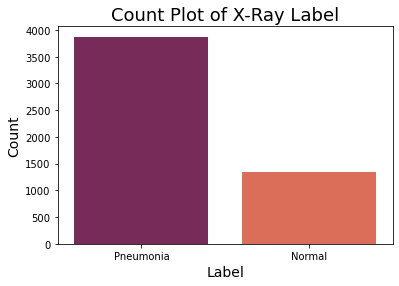

In [13]:
xray_data_train = []

for i in train_data:
    if(i[1] == 0):
        xray_data_train.append("Pneumonia")
    else:
        xray_data_train.append("Normal")
        
# create countplot
sns.countplot(xray_data_train, palette="rocket")     

# add title and axis labels
plt.title("Count Plot of X-Ray Label", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Label", size=14)

plt.show()

### Data Preparation

#### Separate features from labels

In [14]:
# separate features from labels - train data
X_train = []
y_train = []

for feature, label in train_data:
    X_train.append(feature)
    y_train.append(label)

In [15]:
X_train

[array([[18, 28, 29, ..., 13,  7,  1],
        [21, 24, 29, ..., 14,  9,  3],
        [22, 26, 32, ..., 16,  9,  2],
        ...,
        [10,  9,  8, ..., 15, 15, 15],
        [10, 10,  8, ..., 15, 15, 15],
        [10, 10,  8, ..., 15, 15, 15]], dtype=uint8),
 array([[61, 70, 76, ..., 28, 25, 22],
        [75, 81, 80, ..., 28, 24, 23],
        [86, 83, 85, ..., 31, 23, 21],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[ 22,  33,  29, ...,  86, 101, 118],
        [ 27,  35,  33, ..., 116, 121, 115],
        [ 31,  35,  27, ..., 121, 103, 101],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 array([[ 0,  0,  0, ..., 22, 22, 36],
        [ 0,  0,  1, ..., 37, 19, 26],
        [ 0,  0,  8, ..., 59, 39, 25],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [

In [16]:
y_train

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [17]:
# separate features from labels - test data
X_test = []
y_test = []

for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

In [18]:
# separate features from labels - validation data
X_val = []
y_val = []

for feature, label in val_data:
    X_val.append(feature)
    y_val.append(label)

#### Normalize Data

In [19]:
X_train = np.array(X_train) / 255
X_train = X_train.reshape(-1, 150, 150, 1)
y_train = np.array(y_train)

X_val = np.array(X_val) / 255
X_val = X_val.reshape(-1, 150, 150, 1)
y_val = np.array(y_val)

X_test = np.array(X_test) / 255
X_test = X_test.reshape(-1, 150, 150, 1)
y_test = np.array(y_test)

#### Augment Data

In [20]:
# add synthetically modified data by altering the training data with small random transformations to reproduce variations
data_generator = ImageDataGenerator( #Generate batches of tensor image data with real-time data augmentation.
        featurewise_center=False,  #Boolean. Set input mean to 0 over the dataset, feature-wise.
        samplewise_center=False,  #Boolean. Set each sample mean to 0.
        featurewise_std_normalization=False, #Boolean. Divide inputs by std of the dataset, feature-wise.
        samplewise_std_normalization=False, #Boolean. Divide each input by its std.
        zca_whitening=False, #Boolean. Apply ZCA whitening.
        rotation_range = 10, #Int. Degree range for random rotations.
        zoom_range = 0.1, #Float or [lower, upper]. Range for random zoom.
        width_shift_range=0.1, #Float, 1-D array-like or int. Fraction of total pixels.
        height_shift_range=0.1, #Float, 1-D array-like or int. Fraction of total pixels.
        horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
        vertical_flip=False) #Boolean. Randomly flip inputs vertically.

# run data generator on training features
data_generator.fit(X_train, seed=42)

### Model Training

#### Create Neural Network Model

In [21]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

#### Fit model

In [22]:
# Reduce learning rate when a metric has stopped improving.
rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, #number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1, #int. 0: quiet, 1: update messages.
                                            factor=0.3, #factor by which the learning rate will be reduced. new_lr = lr * factor.
                                            min_lr=0.000001 #lower bound on the learning rate.
                                           )

cnn = model.fit(data_generator.flow(X_train, y_train, batch_size = 32, seed=42),
                    epochs=10, 
                    validation_data=data_generator.flow(X_val, y_val, seed=42),
                    callbacks=[rlr]
                   )

Epoch 1/10
163/163 [==============================] - 179s 1s/step - loss: 0.4763 - accuracy: 0.8635 - val_loss: 25.5197 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 179s 1s/step - loss: 0.2355 - accuracy: 0.9116 - val_loss: 23.8135 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9369
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 179s 1s/step - loss: 0.1848 - accuracy: 0.9369 - val_loss: 41.5613 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 179s 1s/step - loss: 0.1206 - accuracy: 0.9595 - val_loss: 31.1246 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 178s 1s/step - loss: 0.1122 - accuracy: 0.9620 - val_loss: 1.7915 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 178s 1s/step - loss: 0.1096 - accuracy: 0.9603 - val_loss: 17.

### Model Evaluation

#### Calculate Loss & Accuracy

In [23]:
# test on reserved data
print("Model Loss:" , model.evaluate(X_test,y_test)[0]*100 , "%")
print("Model Accuracy:" , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 111ms/step - loss: 0.4625 - accuracy: 0.9071
Model Loss: 0.46253225207328796
20/20 [==============================] - 2s 110ms/step - loss: 0.4625 - accuracy: 0.9071
Model Accuracy: 90.70512652397156 %


#### Plot Accuracy

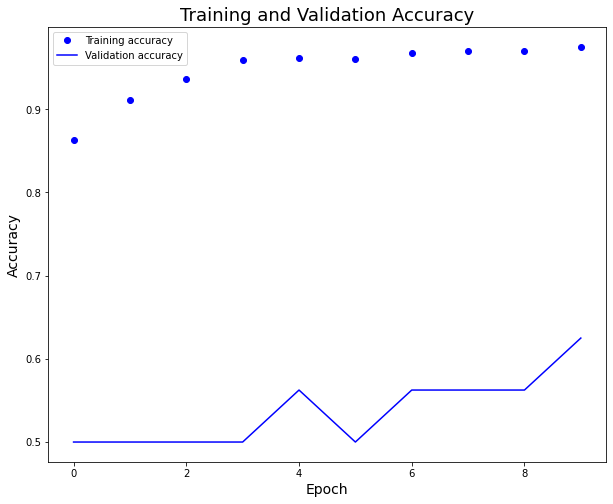

In [24]:
# set figure size
plt.figure(figsize = (10,8))

# get training & validation accuracy from model
accuracy = cnn.history['accuracy']
val_accuracy = cnn.history['val_accuracy']
epochs = range(len(accuracy))

# plot the accuracy of training and validation data
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

# add title
plt.title('Training and Validation Accuracy', size=18)
plt.ylabel("Accuracy", size=14)
plt.xlabel("Epoch", size=14)

# add legend
plt.legend(loc=0)

# display plot
plt.show()

#### Plot Loss

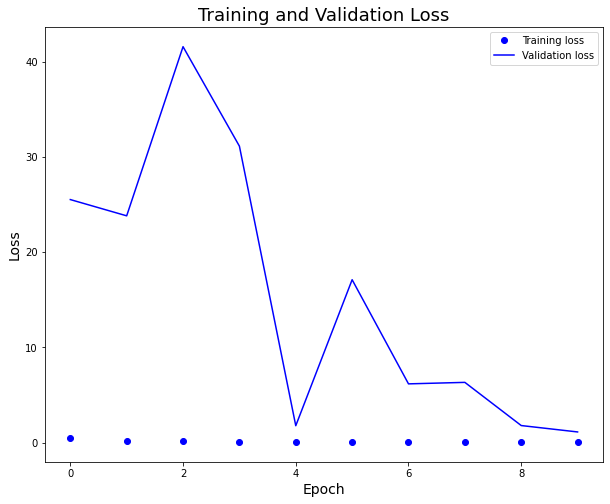

In [25]:
# set figure size
plt.figure(figsize = (10,8))

# get training & validation loss from model
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

# plot the loss of training and validation data
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

# add title
plt.title('Training and Validation Loss', size=18)
plt.ylabel("Loss", size=14)
plt.xlabel("Epoch", size=14)

# add legend
plt.legend(loc=0)

# display plot
plt.show()

#### Make predictions

In [26]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:30]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

#### Classification Report

In [27]:
# create classification report
print(classification_report(y_test, predictions, target_names = target_labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.88      0.98      0.93       390
      NORMAL       0.96      0.79      0.86       234

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



#### Confusion Matrix

In [28]:
# create confusion matrix
conf = confusion_matrix(y_test,predictions)

conf

array([[382,   8],
       [ 50, 184]], dtype=int64)

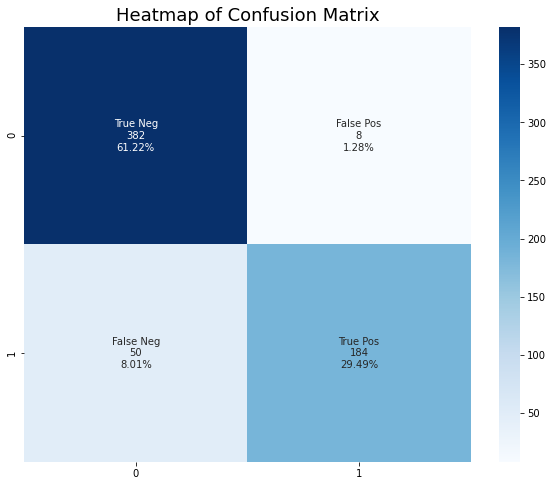

In [29]:
# set figure size
plt.figure(figsize = (10,8))

# define group labels
group_names = ['True Neg','False Pos','False Neg','True Pos']

# get counts
group_counts = ["{0:0.0f}".format(value) for value in
                conf.flatten()]

# get percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     conf.flatten()/np.sum(conf)]

# combine all labels
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# create heatmap using confusion matrix & assigning combined labels
sns.heatmap(conf, annot=labels, fmt='', cmap='Blues')

# add title
plt.title('Heatmap of Confusion Matrix', size=18)

# display plot
plt.show()

#### Sample Incorrect Predictions

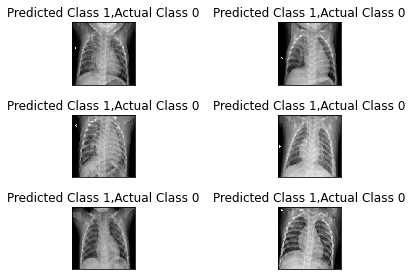

In [30]:
# gather incorrect predictions
incorrect = np.nonzero(predictions != y_test)[0]

i = 0

# show images
for n in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[n].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[n], y_test[n]))
    plt.tight_layout()
    i += 1